In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs   

In [ ]:
def show(X):
    if X.dim() == 3 and X.size(0) == 3:
        plt.imshow( np.transpose(  X.numpy() , (1, 2, 0))  )
        plt.show()
    elif X.dim() == 2:
        plt.imshow(   X.numpy() , cmap='gray'  )
        plt.show()
    else:
        print('WRONG TENSOR SIZE')

In [ ]:
def show_prob_cifar(p):


    p=p.data.squeeze().numpy()

    ft=15
    label = ('airplane', 'automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship','Truck' )
    #p=p.data.squeeze().numpy()
    y_pos = np.arange(len(p))*1.2
    target=2
    width=0.9
    col= 'blue'
    #col='darkgreen'

    plt.rcdefaults()
    fig, ax = plt.subplots()

    # the plot
    ax.barh(y_pos, p, width , align='center', color=col)

    ax.set_xlim([0, 1.3])
    #ax.set_ylim([-0.8, len(p)*1.2-1+0.8])

    # y label
    ax.set_yticks(y_pos)
    ax.set_yticklabels(label, fontsize=ft)
    ax.invert_yaxis()  
    #ax.set_xlabel('Performance')
    #ax.set_title('How fast do you want to go today?')

    # x label
    ax.set_xticklabels([])
    ax.set_xticks([])
    #x_pos=np.array([0, 0.25 , 0.5 , 0.75 , 1])
    #ax.set_xticks(x_pos)
    #ax.set_xticklabels( [0, 0.25 , 0.5 , 0.75 , 1] , fontsize=15)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_linewidth(4)


    for i in range(len(p)):
        str_nb="{0:.2f}".format(p[i])
        ax.text( p[i] + 0.05 , y_pos[i] ,str_nb ,
                 horizontalalignment='left', verticalalignment='center',
                 transform=ax.transData, color= col,fontsize=ft)



    plt.show()


In [ ]:
import os.path
def check_cifar_dataset_exists(path_data='../../data/'):
    flag_train_data = os.path.isfile(path_data + 'cifar/train_data.pt') 
    flag_train_label = os.path.isfile(path_data + 'cifar/train_label.pt') 
    flag_test_data = os.path.isfile(path_data + 'cifar/test_data.pt') 
    flag_test_label = os.path.isfile(path_data + 'cifar/test_label.pt') 
    if flag_train_data==False or flag_train_label==False or flag_test_data==False or flag_test_label==False:
        print('CIFAR dataset missing - downloading...')
        import torchvision
        import torchvision.transforms as transforms
        trainset = torchvision.datasets.CIFAR10(root=path_data + 'cifar/temp', train=True,
                                        download=True, transform=transforms.ToTensor())
        testset = torchvision.datasets.CIFAR10(root=path_data + 'cifar/temp', train=False,
                                       download=True, transform=transforms.ToTensor())  
        train_data=torch.Tensor(50000,3,32,32)
        train_label=torch.LongTensor(50000)
        for idx , example in enumerate(trainset):
            train_data[idx]=example[0]
            train_label[idx]=example[1]
        torch.save(train_data,path_data + 'cifar/train_data.pt')
        torch.save(train_label,path_data + 'cifar/train_label.pt') 
        test_data=torch.Tensor(10000,3,32,32)
        test_label=torch.LongTensor(10000)
        for idx , example in enumerate(testset):
            test_data[idx]=example[0]
            test_label[idx]=example[1]
        torch.save(test_data,path_data + 'cifar/test_data.pt')
        torch.save(test_label,path_data + 'cifar/test_label.pt')
    return path_data

Download the CIFAR dataset -- check the size carefully!

In [ ]:
data_path=check_cifar_dataset_exists()

train_data=torch.load(data_path+'cifar/train_data.pt')
train_label=torch.load(data_path+'cifar/train_label.pt')
test_data=torch.load(data_path+'cifar/test_data.pt')
test_label=torch.load(data_path+'cifar/test_label.pt')

print(train_data.size())

CIFAR dataset missing - downloading...



Extracting ../../data/cifar/temp/cifar-10-python.tar.gz to ../../data/cifar/temp
Files already downloaded and verified
torch.Size([50000, 3, 32, 32])


Make a ONE layer net class.

In [ ]:
class one_layer_net(nn.Module):

    def __init__(self, input_size, output_size):
        super(one_layer_net , self).__init__()
        self.linear_layer = nn.Linear( input_size, output_size , bias=True)
        
    def forward(self, x):
        scores = self.linear_layer(x)
        return scores

Build the net.

In [ ]:
net=one_layer_net(3072,10)
print(net)

one_layer_net(
  (linear_layer): Linear(in_features=3072, out_features=10, bias=True)
)


Choose the criterion and optimizer. Also choose:

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.SGD( net.parameters() , lr=0.01 )
bs=20

Do 50 passes through the training set.

In [ ]:
for epoch in range(50):
    
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(50000)
 
    for count in range(0,50000,bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices]
        minibatch_label= train_label[indices]

        # reshape the minibatch
        inputs = minibatch_data.view(bs,3072)

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        
        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    
    print('epoch=',epoch, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')

epoch= 0 	 loss= 1.9561981432437896 	 error= 69.38600001335145 percent
epoch= 1 	 loss= 1.8642612622261048 	 error= 65.28999990463257 percent
epoch= 2 	 loss= 1.8350322340011598 	 error= 64.1079999923706 percent
epoch= 3 	 loss= 1.8167315202236176 	 error= 63.533999979496 percent
epoch= 4 	 loss= 1.8077953305244445 	 error= 63.05200001955033 percent
epoch= 5 	 loss= 1.7979916991710663 	 error= 62.52800004005432 percent
epoch= 6 	 loss= 1.7913448699474335 	 error= 62.52799998998641 percent
epoch= 7 	 loss= 1.7848079527854919 	 error= 61.83399996757507 percent
epoch= 8 	 loss= 1.7777194638252258 	 error= 61.609999997615816 percent
epoch= 9 	 loss= 1.7734040201187133 	 error= 61.31799995899201 percent
epoch= 10 	 loss= 1.7704258152723313 	 error= 61.52599997282028 percent
epoch= 11 	 loss= 1.7636261817932128 	 error= 60.916000003814695 percent
epoch= 12 	 loss= 1.7641877146959304 	 error= 60.79799999713897 percent
epoch= 13 	 loss= 1.7589309598445892 	 error= 60.727999989986415 percent
ep

So we are doing around 59% error on the training set, how much are we doing on test set?

In [ ]:
running_error=0
num_batches=0


for i in range(0,10000,bs):

    # extract the minibatch
    minibatch_data =  ## complete here
    minibatch_label= ## complete here

    # reshape the minibatch
    inputs = ## complete here

    # feed it to the network
    scores=## complete here 

    # compute the error made on this batch
    error = ## complete here
    
    # add it to the running error
    running_error += ## complete here

    num_batches+=1


# compute error rate on the full test set
total_error = ## complete here

print( 'error rate on test set =', total_error*100 ,'percent')

error rate on test set = 67.13000003099442 percent


Choose image at random from the test set and see how good/bad are the predictions

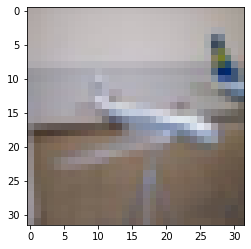

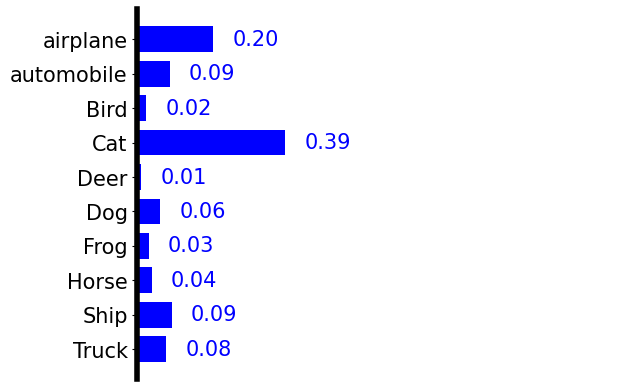

In [ ]:
# choose a picture at random
idx=randint(0, 10000-1)
im=test_data[idx]

# diplay the picture
show(im)

# feed it to the net and display the confidence scores
scores =  net( im.view(1,3072)) 
probs= F.softmax(scores, dim=1)
show_prob_cifar(probs)